# Divergence (replacement) model

As in [Skoglund et al., 2014](https://academic.oup.com/mbe/article/31/9/2516/2925787):
- two populations diverged 10000 years ago
- 10 ancient individuals sampled between 10000 and 5500 years from one population
- 30 individuals sampled from the other population, between 5000 years ago and the present (10 ancient individuals spread out in time and 20 present-day individuals)

This simulation could correspond to a scenario where the older population was replaced with new colonizers from another population.

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def modernSamples(n, deme):
    """
    n = number of modern samples (haploids)
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,n):
        samples.append(msprime.Sample(deme,0))
    return(samples)


def ancientSamples(nb, age, deme):
    """
    nb = number of ancient samples (haploids)
    age = age of the samples, in generations
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,nb):
        samples.append(msprime.Sample(deme, age))
    return(samples)

def createSamples(nbA, ages, deme):
    """
    nbM = number of modern samples (diploids)
    nbA = number of ancient samples (diploids)
    age = list of past generations for ancient samples
    """
    samples = []
    for i in ages:
        samples += ancientSamples(2*nbA, i, deme)
    return samples

In [3]:
def run_sim(num_replicates, nbA, nbM, l, samples, population_configurations, demographic_events):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 1, samples = samples,
                                  mutation_rate=5e-6, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events = demographic_events)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM+nbA*l,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [4]:
def plot_pca_coords(coords, model, pc1, pc2, ax, ages, nbM, nbA):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label=0, color=type_color[0], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

In [5]:
def plot_PC_maps(coords, model, pc, ax, ages, nbM, nbA):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    # modern samples
    y = coords[0:nbM, pc]
    x = np.zeros(len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label=0, color=type_color[0], markersize=6, mec='k', mew=.5)
    i = nbM
    # ancient samples
    for a in ages:
        y = coords[i:i+nbA, pc]
        ax.plot(int(a)*25, y, marker='o', linestyle=' ', label=a, color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += 1
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Age (years b.p.)')

In [6]:
Ne = 5000
nbM = 20
nbA = 1

ages0 = [20,40,60,80,100,120,140,160,180,200]
ages1 = [220,240,260,280,300,320,340,360,380,400]
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] 
samples += createSamples(nbA, ages0, 0) 
samples += createSamples(nbA, ages1, 1)

population_configurations = [
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
        msprime.MassMigration(401, source=1, dest=0)]

dp = msprime.DemographyDebugger(           
    population_configurations=population_configurations,
    demographic_events=demographic_events)
dp.print_history()

Epoch: 0 -- 401.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  5e+03    5e+03               0 |     0        0    
1 |  5e+03    5e+03               0 |     0        0    

Events @ generation 401.0
   - Mass migration: lineages move from 1 to 0 with probability 1.0
Epoch: 401.0 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  5e+03    5e+03               0 |     0        0    
1 |  5e+03    5e+03               0 |     0        0    



In [7]:
g = allel.model.GenotypeArray(run_sim(100000, nbA, nbM, len(ages0)+len(ages1), samples, population_configurations, demographic_events))
g

<GenotypeArray shape=(53625, 40, 2) dtype=int8>
0/0 0/0 1/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 1/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 1/0 ... 0/0 0/1 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [8]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn, scaler=None)
coords2, model2 = allel.stats.pca(gn)

In [9]:
times = [0] + list(map(str, ages0)) + list(map(str, ages1))
palette = sns.color_palette("hls", len(times))
i = 0
type_color = {}
for t in times:
    type_color[t] = palette[i]
    i += 1

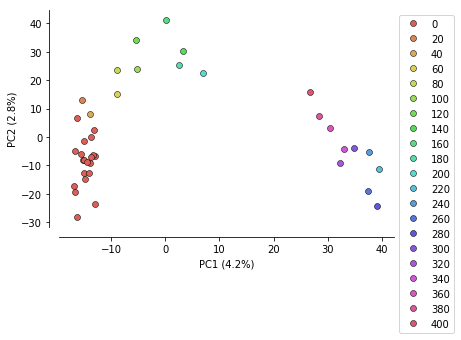

In [10]:
fig, ax = plt.subplots()
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax, ages0+ages1, nbM, nbA)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

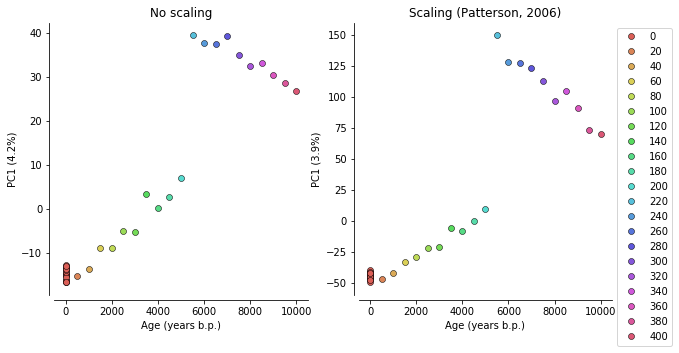

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
plot_PC_maps(coords, model, 0, ax, ages0+ages1, nbM, nbA)
ax.set_title("No scaling")
ax = fig.add_subplot(1,2,2)
plot_PC_maps(coords2, model2, 0, ax, ages0+ages1, nbM, nbA)
ax.set_title("Scaling (Patterson, 2006)")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Individuals sampled before the replacement event show a trajectory along PC1 through time that is angled away from the individuals in the population that replaced the previous population.